In [1]:
%pip install pandas geopandas numpy pyarrow folium matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import os.path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import folium


In [3]:
def create_bounding_shape(gdf):
    bbox = gdf.total_bounds
    rectangle = shapely.geometry.box(*bbox)
    out = gpd.GeoDataFrame({'geometry': [rectangle]}, crs=gdf.crs)
    return out

def invert_mask(mask_gdf):
    target = create_bounding_shape(mask_gdf)
    out = gpd.overlay(target, mask_gdf, how="difference")
    return out

In [4]:
def fill_holes(gdf):
    out = gdf.copy()
    for index, row in out.iterrows():
        geometry = row['geometry']
        if isinstance(geometry, shapely.geometry.MultiPolygon):
            new_polygons = []
            for polygon in geometry.geoms:
                new_polygon = shapely.geometry.Polygon(polygon.exterior)
                new_polygons.append(new_polygon)
            new_geometry = shapely.geometry.MultiPolygon(new_polygons)
        elif isinstance(geometry, shapely.geometry.Polygon):
            new_geometry = shapely.geometry.Polygon(geometry.exterior)
        else:
            continue
        out.at[index, 'geometry'] = new_geometry
    return out


In [5]:
def translate_overlay(target, overlay, how='centroid', fraction=None):
    aligned = overlay.to_crs(target.crs)
    if how == 'centroid':
        to = target.geometry.unary_union.centroid
        start = aligned.geometry.unary_union.centroid
        translation_vector = (to.x - start.x, to.y - start.y)
    elif how == 'fraction':
        [min_x, min_y, max_x, max_y] = target.total_bounds
        offset_x = (max_x - min_x)*fraction[0]
        offset_y = (max_y - min_y)*fraction[1]
        to = (min_x + offset_x, min_y + offset_y)
        start = aligned.total_bounds[0:2]
        translation_vector = (to[0] - start[0], to[1] - start[1])
    else:
        raise Exception(f"Unsupported translation 'how': '{how}'")
    translated = overlay.copy()
    translated.geometry = aligned.geometry.translate(translation_vector[0], translation_vector[1])
    return translated


# 1 Million Ann Arborites

Compare Ann Arbor to various cities around the world. The tentative list of cities is:

In [61]:
OSM_DIR = "../osm"
POP_DIR = "../pop"
BOUNDARY_DIR = "../boundaries"

data = {
    "detroit": {
        "name": "Detroit",
        "osm": "michigan.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "detroit-boundary.shp",
    },
    "chicago": {
        "name": "Chicago",
        "osm": "illinois.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "chicago-boundary.shp",
        "how": "fraction",
        "fraction": (0.49, 0.4),
    },
    "denver": {
        "name": "Denver",
        "osm": "colorado.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "denver-boundary.shp",
        "how": "fraction",
        "fraction": (0.115, 0.25),
    },
    "new-york-city": {
        "name": "New York City",
        "osm": "colorado.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "new-york-city-boundary.shp",
    },
    "san-francisco": {
        "name": "San Francisco",
        "osm": "california.osm.pbf",
        "pop": "usa-population-2020.tif",
        "mask": "san-francisco-mask.shp",
    },
    "paris": {
        "name": "Paris",
        "osm": "france.osm.pbf",
        "pop": "france-population-2020.tif",
        "outline": "paris-boundary-arrondissements.shp",
    },
    "columbus": {
        "name": "Columbus",
        "osm": "ohio.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "columbus-boundary.shp",
    },
    "ann-arbor": {
        "name": "Ann Arbor",
        "osm": "michigan.osm.pbf",
        "pop": "usa-population-2020.tif",
        "outline": "ann-arbor-boundary.shp",
    },
    "philadelphia": {
        "name": "Philadelphia",
        "pop": "usa-population-2020.tif",
        "outline": "philadelphia-boundary.shp",
    },
}

def boundary_file_path(s):
    return os.path.join(BOUNDARY_DIR, s)

def load_city_outline(city):
    if "outline" in city:
        return gpd.read_file(boundary_file_path(city["outline"]))
    elif "mask" in city:
        mask = gpd.read_file(boundary_file_path(city["mask"]))
        return invert_mask(mask)
    raise Exception(f"Missing mask or outline for '{city.get('name', '')}'")

In [43]:
class City:

    cache = dict()

    def __init__(self, obj):
        self.name = obj['name']
        self.outline = load_city_outline(obj)
        self.how = obj.get('how', 'centroid')
        self.fraction = obj.get('fraction', None)

In [62]:
sf = City(data['san-francisco'])
a2 = City(data['ann-arbor'])
denver = City(data['denver'])
detroit = City(data['detroit'])
chicago = City(data['chicago'])
columbus = City(data['columbus'])
paris = City(data['paris'])
nyc = City(data['new-york-city'])
philly = City(data['philadelphia'])

cities = [chicago, columbus, denver, detroit, nyc, paris, philly, sf]

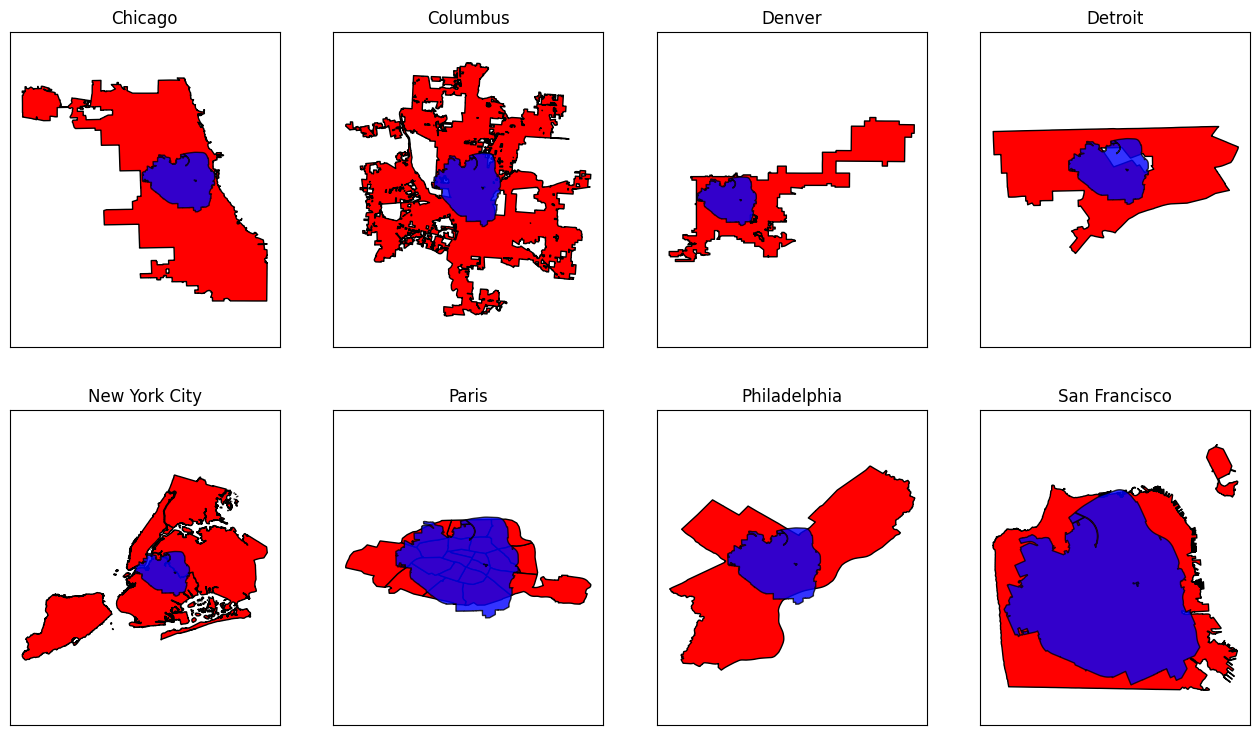

In [64]:

fix, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
axs = axs.flatten()
for i, city in enumerate(cities):
    overlaid_a2 = translate_overlay(city.outline, fill_holes(a2.outline), how=city.how, fraction=city.fraction)
    city.outline.plot(ax=axs[i], color='red', edgecolor='k')
    overlaid_a2.plot(ax=axs[i], color='blue', edgecolor='k', alpha=0.8)
    axs[i].axis('equal')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(city.name)

plt.show()

In [9]:
def city_style(feature):
    return {
        "fillColor": "#ffff00",
        "color": "black",
        "weight": 2,
    }

#for city_id in cities:
#    city = data[city_id]
#    name = city["name"]
#    print(f"Reading data for {name}")
#    boundary_shp = gpd.read_file(boundary_file_path(city['boundary'])).to_crs(epsg=4326)
#    print(f"Input CRS = {boundary_shp.crs}")
#    bbox = boundary_shp.total_bounds
#    print(bbox)
#    [min_long, min_lat, max_long, max_lat] = bbox
#    centroid = boundary_shp.centroid.iloc[0]
#    m = folium.Map(location=[centroid.y, centroid.x], zoom_control=False, max_bounds=True, min_long=min_long, max_long=max_long, min_lat=min_lat, max_lat=max_lat)
#    layer = folium.GeoJson(boundary_shp, name=name, style_function=city_style).add_to(m)
#    [[ a, b], [c, d]] = layer.get_bounds()
#    print(layer.get_bounds())
#    print([b, a, d, c])
#    m.fit_bounds(layer.get_bounds())
